In [ ]:
!pip install -U librosa pytorch-lightning omegaconf transformers datasets
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
!python -m pip install torchaudio > /dev/null
!python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-kdu0ja_7


In [ ]:
!pip install wavaugment

In [ ]:
import torch
import torch.nn as nn
from omegaconf import OmegaConf, DictConfig
import augment
import random
import torchaudio.transforms as T
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim import Adam, lr_scheduler
from transformers import AutoModel, WhisperTokenizer, WhisperFeatureExtractor

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/nguyenanh-projects/streaming-asr/conf/sim_clr_model.yaml"

In [ ]:
root_dir = "/content/drive/MyDrive/nguyenanh-projects/streaming-asr/dataset/audio"
dataset = "/content/drive/MyDrive/nguyenanh-projects/streaming-asr/dataset/train-15-samples.json"

# Helper functions ⚡⚡⚡

In [ ]:
import yaml

def get_configs(path: str):
    params = yaml.safe_load(open(path, 'r', encoding='utf-8'))
    return params

In [ ]:
def visualize(spectrogram):
    plt.figure(figsize=(130, 130)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

# Define Transforms module for SimCLR ⚡⚡⚡

In [ ]:
import augment
import torchaudio.transforms as T
import random
import torchaudio
import torch.nn as nn
import numpy as np

class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip. This method is sourced from an earlier release of torchaudio and
    is no longer present in current versions.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db

class AudioTransforms:
    # transform function contains
    # pitch shift, reverbration, adding noise
    # advanced techniques - time masking, freq masking
    def __init__(self, rate=16_000) -> None:
        self.rate = rate
        self.whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

        # transform function input should be mel spectrogram
        self.augment_waveform = [
            self.pitch_shift,  # shifting audio pitch
            self.reverb_audio,  # reverb audio with room echo sound
        ]

        self.augment_melspec = [self.time_mask, self.freq_mask]

    def _load_audio_signal(self, audio_path):
        audio_array, _ = torchaudio.load(audio_path)
        return audio_array

    def transforms_wavform_2_melspec(self, audio_array):
        # melspec transform function
        # using WhisperFeatureExtractor to compute mel-spectrogram
        mel_spec = self.whisper_feature_extractor(audio_array, self.rate, return_tensors="pt").input_features #
        mel_spec = SpectrogramToDB(stype='magnitude', top_db=8000)(mel_spec)
        return mel_spec

    def _feature_extraction_original(self, audio_path):
        # melspec transform function
        audio_array = self._load_audio_signal(audio_path)
        audio_array = audio_array.squeeze(0) # remove batch dim
        mel_spec = self.transforms_wavform_2_melspec(audio_array)
        return mel_spec

    def audio_augment(self, audio_path):
        audio_array = self._load_audio_signal(audio_path)
        # random audio aug function
        for funcs in self.augment_waveform:
            audio_array = funcs(audio_array)

        audio_array = audio_array.squeeze(0) # remove batch dim

        # convert to mel-spectrogram
        mel_spec = self.transforms_wavform_2_melspec(audio_array)
        # random aug mel spectrogram
        for funcs in self.augment_melspec:
            mel_spec = funcs(mel_spec)

        return mel_spec

    def reverb_audio(self, audio_array):
        reverbered_audio = (
            augment.EffectChain()
            .reverb(100, 80, 90)
            .channels(1)
            .apply(audio_array, src_info={"rate": self.rate})
        )

        return reverbered_audio

    def pitch_shift(self, audio_array):
        pitch_shifted_audio = (
            augment.EffectChain()
            .pitch(200)
            .rate(self.rate)
            .apply(audio_array, src_info={"rate": self.rate})
        )
        return pitch_shifted_audio

    def time_mask(self, spec, T=40, num_masks=1, replace_with_zero=False):
        cloned = spec.clone()
        len_spectro = cloned.shape[2]

        for i in range(0, num_masks):
            t = random.randrange(0, T)
            t_zero = random.randrange(0, len_spectro - t)

            # avoids randrange error if values are equal and range is empty
            if (t_zero == t_zero + t): return cloned

            mask_end = random.randrange(t_zero, t_zero + t)
            if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
            else: cloned[0][:,t_zero:mask_end] = cloned.mean()
        return cloned

    def freq_mask(self, spec, F=30, num_masks=2, replace_with_zero=False):
        cloned = spec.clone()
        num_mel_channels = cloned.shape[1]

        for i in range(0, num_masks):
            f = random.randrange(0, F)
            f_zero = random.randrange(0, num_mel_channels - f)

            # avoids randrange error if values are equal and range is empty
            if (f_zero == f_zero + f): return cloned

            mask_end = random.randrange(f_zero, f_zero + f)
            if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
            else: cloned[0][f_zero:mask_end] = cloned.mean()

        return cloned

    def add_noise(self):
        pass

    def __call__(self, input):
        # input is audio path
        x1 = self.audio_augment(input) # keep one original
        x2 = self.audio_augment(input)
        return x1, x2

# Define Dataloader for SimCLR ⚡⚡⚡

In [ ]:
from torch.utils.data import DataLoader, Dataset
from datasets import Dataset as HFDataset
import os

# dataset
class SimCLRDataset(Dataset):
    def __init__(self, conf: DictConfig = None, transforms=None) -> None:
        super().__init__()
        # conf OmegaConf create
        # transforms function for augment audio signal
        self.conf = OmegaConf.create(conf)
        self.transforms = transforms
        self.dataset = self._create_hf_dataset()
        self.root_dir = self.conf.trainer.root_dir # setup root dir

    def __getitem__(self, index):
        # input contain audio path
        # this transforms function will process with audio array
        # then transforms to melspec and aug this input
        audio_path = self.dataset[index]["audio_filepath"]
        audio_path = os.path.join(self.root_dir, audio_path)
        transcript = self.dataset[index]["text"]

        if self.transforms:
            augmented_data = self.transforms(audio_path) # input (audio path)

        return augmented_data, transcript

    def _create_hf_dataset(self):
        # data path included in conf (OmegaConf)
        # read json file
        dataset = HFDataset.from_json(self.conf.trainer.train_path)
        return dataset

    def __len__(self):
        return len(self.dataset)


# dataloader
class SimCLRDataloader(DataLoader):
    def __init__(self):
        super().__init__()

# Define basic ASR model with pretrained as base model and MLP on top ⚡⚡⚡

In [ ]:


class BasicASRModel(nn.Module):
    def __init__(self, conf) -> None:
        super().__init__()
        self.conf = conf # already create as DictConfig with OmegaConf
        self.encoder, self.tokenizer = self._pretrained_encoder()

        # projection head
        self.mlp = nn.Sequential(
            nn.Linear(in_features=self.conf.model.mlp.in_feats,
                      out_features=self.conf.model.mlp.out_feats, bias=True),
            nn.ReLU(), nn.Dropout(p=0.1),
            nn.Linear(in_features=self.conf.model.mlp.out_feats,
                      out_features=128, bias=True))

        self.softmax = nn.Softmax(dim=-1) # softmax the last dim

    def _pretrained_encoder(self):
        # load pretrained model
        asr_model = AutoModel.from_pretrained(self.conf.model.pretrained_model)
        # tokenizer
        asr_tokenizer = WhisperTokenizer.from_pretrained(self.conf.model.pretrained_model)

        encoder = asr_model.encoder

        # freeze encoder
        # if self.conf.model.freeze == True:
        #     for params in encoder.parameters():
        #         params.requires_grad = False

        return encoder, asr_tokenizer

    def forward(self, x: torch.Tensor):
        encoder_out = self.encoder(x).last_hidden_state
        out = self.mlp(encoder_out)
        out = self.softmax(out)
        return out

In [ ]:
conf = get_configs(path)
conf["model"]["pretrained_model"] = "openai/whisper-base"
conf["model"]["freeze"] = True
conf["model"]["mlp"]["in_feats"] = 512
conf["model"]["mlp"]["out_feats"] = 512
conf["trainer"]["root_dir"] = root_dir
# trainer
conf["trainer"]["train_path"] = dataset

conf = OmegaConf.create(conf)

audio_transforms = AudioTransforms()
asr_model = BasicASRModel(conf) # model
tokenizer = asr_model.tokenizer
simclr_dataset = SimCLRDataset(conf, audio_transforms) # dataset
simclr_dataloader = DataLoader(dataset=simclr_dataset, batch_size=8, shuffle=True) # nice no need to padding
asr_model
# require grads - 328320
# not - 20918912

BasicASRModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
   

In [ ]:
melspec, transcript = simclr_dataset.__getitem__(1)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [ ]:
m1, m2 = melspec # return 2 augmented melspec
m1.shape, m2.shape

(torch.Size([1, 80, 3000]), torch.Size([1, 80, 3000]))

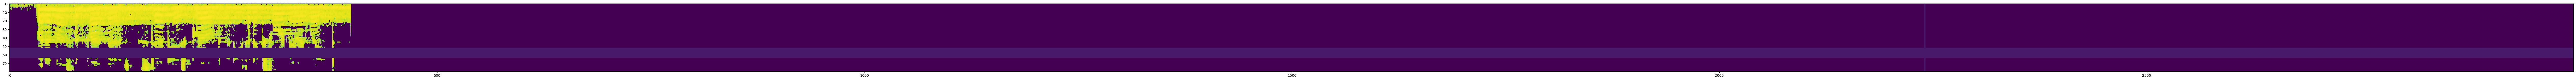

(1, 80, 3000)

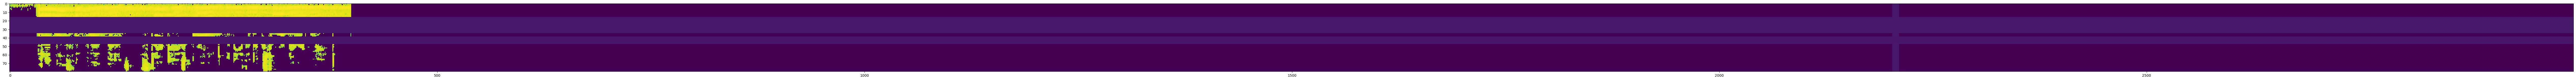

(1, 80, 3000)

In [ ]:
visualize(m1.detach().numpy())
visualize(m2.detach().numpy())

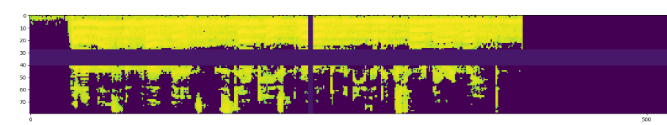

## Cat 2 samples and feed to network ❗

In [ ]:
zi = asr_model(m1)
zj = asr_model(m2)

In [ ]:
t1 = zi.transpose(1,-1)
t2 = zj.transpose(1,-1)

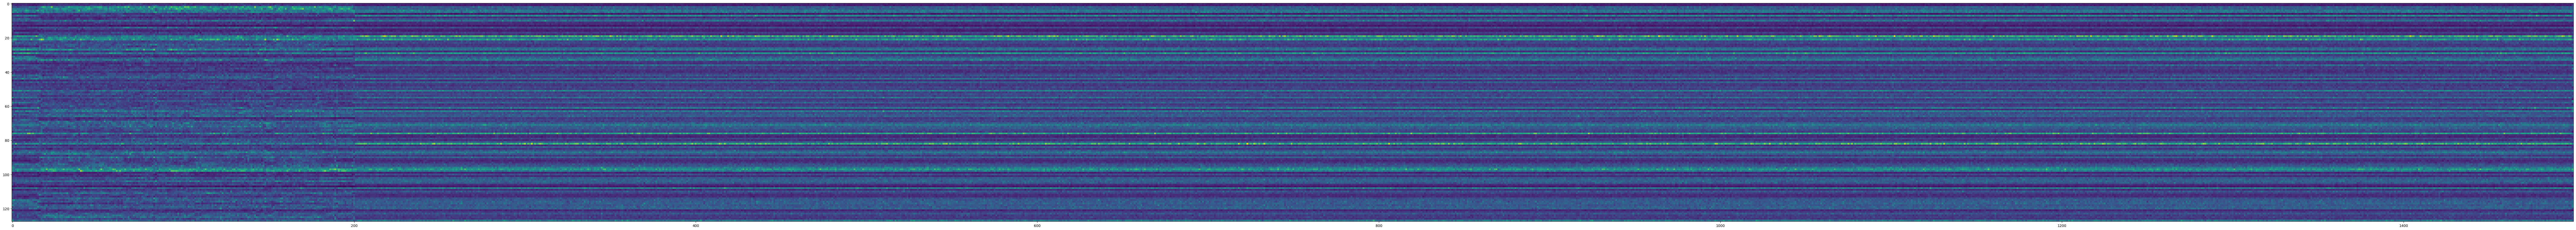

(1, 128, 1500)

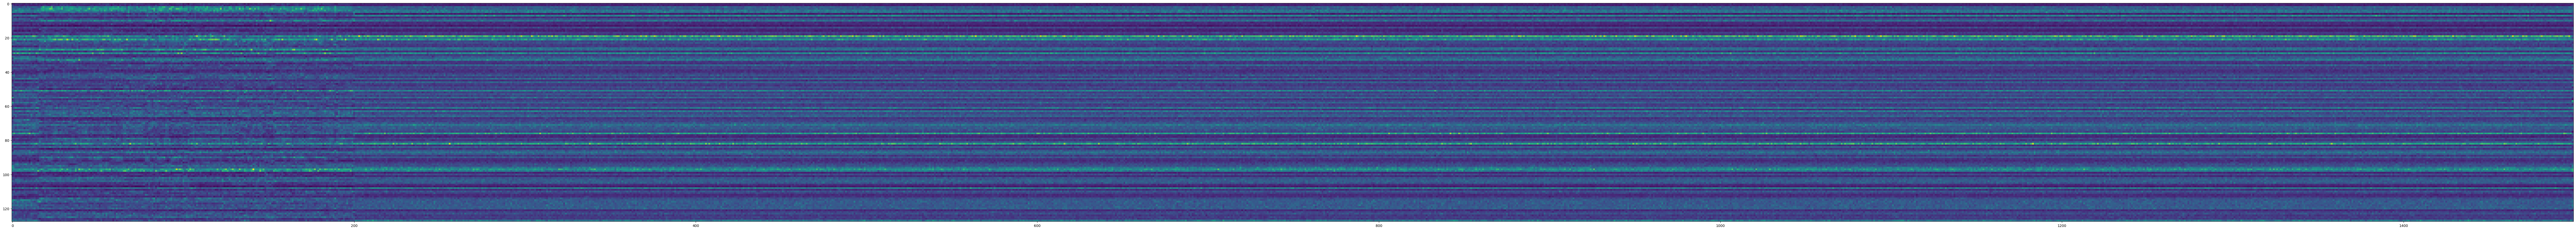

(1, 128, 1500)

In [ ]:
visualize(t1.detach().numpy())
visualize(t2.detach().numpy())

In [ ]:
rep = torch.cat((zi, zj), dim=0)

In [ ]:
rep.shape

torch.Size([2, 1500, 128])

In [ ]:
sim_matrix = F.cosine_similarity(rep.unsqueeze(1), rep.unsqueeze(0), dim=-1)
sim_matrix = torch.exp(sim_matrix / 0.55)

In [ ]:
sim_matrix

tensor([[[6.1606, 6.1606, 6.1606,  ..., 6.1606, 6.1606, 6.1606],
         [6.0353, 6.0762, 5.9831,  ..., 6.0344, 5.9926, 6.0793]],

        [[6.0353, 6.0762, 5.9831,  ..., 6.0344, 5.9926, 6.0793],
         [6.1606, 6.1606, 6.1606,  ..., 6.1606, 6.1606, 6.1606]]],
       grad_fn=<ExpBackward0>)

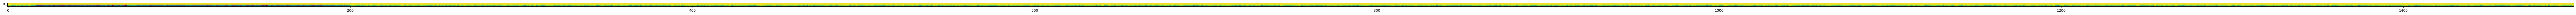

(2, 2, 1500)

In [ ]:
visualize(sim_matrix.detach().numpy())

# Define SimCLR framework ⚡⚡⚡
link: https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/

In [ ]:
class SimCLR(pl.LightningModule):
    def __init__(self, conf: DictConfig = None) -> None:
        super().__init__()
        self.conf = OmegaConf.create(conf)
        self.asr_model = BasicASRModel(conf)
        self.temperature = 0.55

    def configure_optimizers(self):
        optim = Adam(
            self.model.parameters(),
            lr=self.conf.model.train.lr,
            weight_decay=self.conf.model.train.weight_decay,
        )

        scheduler = lr_scheduler.CosineAnnealingLR(
            optim,
            T_max=self.conf.model.train.max_epochs,
            eta_min=self.conf.model.train.lr / 50,
        )

        return [optim], [scheduler]

    def nt_xent_loss(self, batch, mode="train"):
        # integrate with speech model (asr model)
        melspecs, _ = batch  # get melspec augmented

        xi, xj = melspecs
        zi = self.asr_model(xi)
        zj = self.asr_model(xj)
        # loss
        sim_matrix = torch.exp(self._calc_sim(zi, zj) / self.temperature)


        self.log(mode + "_loss", loss)

        return loss

    def info_nce_loss(self, batch, mode="train"):
        melspecs, _ = batch  # get melspec augmented

        xi, xj = melspecs
        zi = self.asr_model(xi)
        zj = self.asr_model(xj)
        #
        self.log("train_loss")
        return

    def _calc_sim(self, zi, zj):
        representations = torch.cat((zi, zj), dim=0)
        sim_matrx = F.cosine_similarity(
            representations.unsqueeze(1), representations.unsqueeze(0), dim=-1
        )
        return sim_matrx

    def training_step(self, batch, batch_idx):
        # return loss each step - lightning module include backward
        # process not need to pay attention
        return self.nt_xent_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        return self.nt_xent_loss(batch, mode="val")

# Define trainer for SimCLR ⚡⚡⚡

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

# define train simclr
def train_simclr():
  # conf for model
  conf = get_configs(path)
  conf["model"]["pretrained_model"] = "openai/whisper-base"
  conf["model"]["freeze"] = True
  conf["model"]["mlp"]["in_feats"] = 512
  conf["model"]["mlp"]["out_feats"] = 512
  conf["trainer"]["root_dir"] = root_dir

  # trainer
  conf["trainer"]["train_path"] = dataset
  # define object simclr
  simclr_model = SimCLR(conf)
  # wandb
  wandb_logger = WandbLogger(project="SimCLR")
  # trainer
  trainer = pl.Trainer()
  trainer.fit(simclr_model, simclr_dataloader, simclr_dataloader)

# Start training ⚡⚡⚡